In [1]:
import os
import sys
sys.path.append('/home/leo/particle/TrafficFluidsPt/TrafficFluids')
sys.path.append('../datasets')
import numpy as np
from glob import glob
from tensorpack import dataflow
import pandas as pd
import helper
import tqdm
import pickle
from collections import defaultdict
from typing import Dict, Optional
from datasets.argoverse_lane_loader import read_pkl_data
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

In [175]:
model_unequi = torch.load('./weights/ctsconv_map2.pth')
model_equi = torch.load('./weights/rho1_ctsconv_map.pth')
model_reg = torch.load('./weights/reg__ctsconv_map.pth')

In [627]:
num_param = {}
for n, p in model_unequi.named_parameters():
    num_param[n] = p.shape
num_param, np.sum([np.prod(p) for p in list(num_param.values())[:4]]),  np.sum([np.prod(p) for p in list(num_param.values())[:5]])+ 64*69 + 64

({'conv_fluid.kernel': torch.Size([32, 61, 4, 4, 4]),
  'conv_obstacle.kernel': torch.Size([32, 3, 4, 4, 4]),
  'dense_fluid.weight': torch.Size([32, 61]),
  'dense_fluid.bias': torch.Size([32]),
  'convs.0.kernel': torch.Size([64, 96, 4, 4, 4]),
  'convs.1.kernel': torch.Size([64, 64, 4, 4, 4]),
  'convs.2.kernel': torch.Size([64, 64, 4, 4, 4]),
  'convs.3.kernel': torch.Size([3, 64, 4, 4, 4]),
  'denses.0.weight': torch.Size([64, 96]),
  'denses.0.bias': torch.Size([64]),
  'denses.1.weight': torch.Size([64, 64]),
  'denses.1.bias': torch.Size([64]),
  'denses.2.weight': torch.Size([64, 64]),
  'denses.2.bias': torch.Size([64]),
  'denses.3.weight': torch.Size([3, 64]),
  'denses.3.bias': torch.Size([3])},
 133056,
 530752)

In [625]:
num_param = {}
for n, p in model_equi.named_parameters():
    num_param[n] = p.shape
num_param, np.sum([np.prod(p) for p in list(num_param.values())[:5]]), np.sum([np.prod(p) for p in list(num_param.values())[:7]]) + 32*48

({'conv_fluid.outer_weights': torch.Size([20, 16, 3, 2, 2]),
  'conv_fluid.bullseye_weights': torch.Size([20, 16]),
  'conv_obstacle.outer_weights': torch.Size([1, 16, 3, 2, 2]),
  'conv_obstacle.bullseye_weights': torch.Size([1, 16]),
  'dense_fluid.linear.weight': torch.Size([16, 20]),
  'convs.0.outer_weights': torch.Size([48, 32, 3, 2, 2]),
  'convs.0.bullseye_weights': torch.Size([48, 32]),
  'convs.1.outer_weights': torch.Size([32, 32, 3, 2, 2]),
  'convs.1.bullseye_weights': torch.Size([32, 32]),
  'convs.2.outer_weights': torch.Size([32, 32, 3, 2, 2]),
  'convs.2.bullseye_weights': torch.Size([32, 32]),
  'convs.3.outer_weights': torch.Size([32, 1, 3, 2, 2]),
  'convs.3.bullseye_weights': torch.Size([32, 1]),
  'denses.0.linear.weight': torch.Size([32, 48]),
  'denses.1.linear.weight': torch.Size([32, 32]),
  'denses.2.linear.weight': torch.Size([32, 32]),
  'denses.3.linear.weight': torch.Size([1, 32])},
 4688,
 26192)

In [626]:
num_param = {}
for n, p in model_reg.named_parameters():
    num_param[n] = p.shape
num_param, np.sum([np.prod(p) for p in list(num_param.values())[:5]]), np.sum([np.prod(p) for p in list(num_param.values())[:7]])+24*16*8

({'conv_fluid.outer_weights': torch.Size([20, 8, 3, 8, 2]),
  'conv_fluid.bullseye_weights': torch.Size([20, 8]),
  'conv_obstacle.outer_weights': torch.Size([1, 8, 3, 8, 2]),
  'conv_obstacle.bullseye_weights': torch.Size([1, 8]),
  'dense_fluid.1.weights': torch.Size([20, 8, 8]),
  'convs.0.outer_weights': torch.Size([24, 16, 3, 8, 8]),
  'convs.0.bullseye_weights': torch.Size([24, 16, 8]),
  'convs.1.outer_weights': torch.Size([16, 8, 3, 8, 8]),
  'convs.1.bullseye_weights': torch.Size([16, 8, 8]),
  'convs.2.outer_weights': torch.Size([8, 8, 3, 8, 8]),
  'convs.2.bullseye_weights': torch.Size([8, 8, 8]),
  'convs.3.outer_weights': torch.Size([8, 1, 3, 2, 8]),
  'convs.3.bullseye_weights': torch.Size([8, 1]),
  'denses.0.weights': torch.Size([24, 16, 8]),
  'denses.1.weights': torch.Size([16, 8, 8]),
  'denses.2.weights': torch.Size([8, 8, 8]),
  'denses.3.0.weights': torch.Size([8, 1, 8])},
 9512,
 89384)

In [12]:
dataset_path = '/home/leo/particle/argoverse/argoverse_forecasting/'
lane_path = '/home/leo/particle/TrafficFluids/datasets/'

val_path = os.path.join(dataset_path, 'val', 'lane_data2')
train_path = os.path.join(dataset_path, 'train', 'lane_data2')

afl = ArgoverseForecastingLoader(os.path.join(dataset_path, 'val', 'data'))

In [13]:
am = ArgoverseMap()
val_dataset = read_pkl_data(val_path, batch_size=1, shuffle=False, repeat=False)
dataset = read_pkl_data(train_path, batch_size=1, repeat=False, shuffle=True, max_lane_nodes=4000)

In [146]:
data_filtered = dict()
for i,data in tqdm.tqdm(enumerate(dataset)):
    mask = am.get_raster_layer_points_boolean(data['pos_2s'][0].reshape(-1, 3), data['city'][0], "driveable_area")
    mask = mask.reshape(*data['pos_2s'][0].shape[:-1])
    
    data_filtered[i] =  np.sum(data['car_mask'][0]) - np.sum(mask.all(-1))
        
        
data = {k: v[0] for k,v in data.items()}

166895it [02:20, 1189.82it/s]


In [145]:
mask = am.get_raster_layer_points_boolean(data['pos_2s'].reshape(-1, 3), data['city'], "driveable_area")
mask = mask.reshape(*data['pos_2s'].shape[:-1])
np.sum(mask.all(-1)), np.sum(data['car_mask'])

(7, 12.0)

(array([1.43718e+05, 0.00000e+00, 1.97110e+04, 0.00000e+00, 2.84000e+03,
        0.00000e+00, 4.93000e+02, 0.00000e+00, 1.03000e+02, 0.00000e+00,
        0.00000e+00, 2.30000e+01, 0.00000e+00, 3.00000e+00, 0.00000e+00,
        3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0.  , 0.45, 0.9 , 1.35, 1.8 , 2.25, 2.7 , 3.15, 3.6 , 4.05, 4.5 ,
        4.95, 5.4 , 5.85, 6.3 , 6.75, 7.2 , 7.65, 8.1 , 8.55, 9.  ]),
 <a list of 20 Patch objects>)

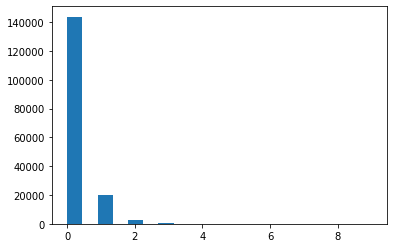

In [153]:
plt.hist(data_filtered.values(), bins=20)
#plt.ylim(0,1000)

In [17]:
displacement = np.linalg.norm(data['pos_2s'][:,-1] - data['pos_2s'][:,0], axis=-1)
displace_mask = displacement < 2
displace_mask[data['track_id0'] == data['agent_id']] = False
convert_keys = (['pos' + str(i) for i in range(31)] + 
                ['vel' + str(i) for i in range(31)] + 
                ['pos_2s', 'vel_2s', 'car_mask'])
for k in convert_keys:
    data[k][displace_mask] = 0

In [44]:
data = afl[0].seq_df
data.shape

(704, 6)

-4.904836177825928

In [75]:
pd.merge(data, df, on=['TIMESTAMP', 'TRACK_ID'], how='right').shape

(1150, 6)

In [54]:
timestps = data['TIMESTAMP'].unique().tolist()
ids = data['TRACK_ID'].unique().tolist()
df = pd.DataFrame({'TIMESTAMP': timestps * len(ids)}).sort_values('TIMESTAMP')
df['TRACK_ID'] = ids * len(timestps)

In [98]:
for i, (idx, sub_df) in enumerate(pd.merge(data, df, on=['TIMESTAMP', 'TRACK_ID'], how='right').groupby('TRACK_ID')):
    if i >= 18:
        break

In [100]:
sub_df.sort_values('TIMESTAMP')

,TIMESTAMP,TRACK_ID,OBJECT_TYPE,X,Y,CITY_NAME
707,3.159693e+08,00000000-0000-0000-0000-000000017296,NaN,NaN,NaN,NaN
716,3.159693e+08,00000000-0000-0000-0000-000000017296,NaN,NaN,NaN,NaN
725,3.159693e+08,00000000-0000-0000-0000-000000017296,NaN,NaN,NaN,NaN
733,3.159693e+08,00000000-0000-0000-0000-000000017296,NaN,NaN,NaN,NaN
741,3.159693e+08,00000000-0000-0000-0000-000000017296,NaN,NaN,NaN,NaN
749,3.159693e+08,00000000-0000-0000-0000-000000017296,NaN,NaN,NaN,NaN
757,3.159693e+08,00000000-0000-0000-0000-000000017296,NaN,NaN,NaN,NaN
766,3.159693e+08,00000000-0000-0000-0000-000000017296,NaN,NaN,NaN,NaN
775,3.159693e+08,00000000-0000-0000-0000-000000017296,NaN,NaN,NaN,NaN
784,3.159693e+08,00000000-0000-0000-0000-000000017296,NaN,NaN,NaN,NaN


In [182]:
class DataProcessor(object):
    def __init__(self, use_interpolate=True):
        self.afl = ArgoverseForecastingLoader(os.path.join(dataset_path, 'val', 'data'))
        self.freq = 0.1
        self.max_car_num = 60
        self.use_interpolate = use_interpolate
    
    def prepare_data(self, scene, afl):

        data, city = self.afl[scene].seq_df, self.afl[scene].city

        lane = np.array([[0., 0., 0.]], dtype=np.float32)
        lane_drct = np.array([[0., 0., 0.]], dtype=np.float32)

        tstmps = data.TIMESTAMP.unique()
        tstmps.sort()

        if self.use_interpolate:
            # TODO: Threshhold, tunable
            data = self._expand_df(data, city)
            data = self._linear_interpolate(data)
        else:
            data = self._filter_imcomplete_data(data, tstmps, 50)
       
        data = self._calc_vel(data, self.freq)

        agent = data[data['OBJECT_TYPE'] == 'AGENT']['TRACK_ID'].values[0]

        car_mask = np.zeros((self.max_car_num, 1), dtype=np.float32)
        car_mask[:len(data.TRACK_ID.unique())] = 1.0

        feat_dict = {'city': city, 
                     'lane': lane, 
                     'lane_norm': lane_drct, 
                     'scene_idx': scene,  
                     'agent_id': agent, 
                     'car_mask': car_mask}

        pos_enc = [subdf[['X', 'Y']].values[np.newaxis,:] 
                   for _, subdf in data[data['TIMESTAMP'].isin(tstmps[:20])].groupby('TRACK_ID')]
        pos_enc = np.concatenate(pos_enc, axis=0)
        pos_enc = self._expand_dim(pos_enc)
        feat_dict['pos_2s'] = self._expand_particle(pos_enc, self.max_car_num, 0)

        vel_enc = [subdf[['vel_x', 'vel_y']].values[np.newaxis,:] 
                   for _, subdf in data[data['TIMESTAMP'].isin(tstmps[:20])].groupby('TRACK_ID')]
        vel_enc = np.concatenate(vel_enc, axis=0)
        vel_enc = self._expand_dim(vel_enc)
        feat_dict['vel_2s'] = self._expand_particle(vel_enc, self.max_car_num, 0)

        for t in range(30):
            pos = data[data['TIMESTAMP'] == tstmps[20 + t]][['X', 'Y']].values
            pos = self._expand_dim(pos)
            feat_dict['pos' + str(t)] = self._expand_particle(pos, self.max_car_num, 0)
            vel = data[data['TIMESTAMP'] == tstmps[20 + t]][['vel_x', 'vel_y']].values
            vel = self._expand_dim(vel)
            feat_dict['vel' + str(t)] = self._expand_particle(vel, self.max_car_num, 0)
            track_id =  data[data['TIMESTAMP'] == tstmps[20 + t]]['TRACK_ID'].values
            feat_dict['track_id' + str(t)] = self._expand_particle(track_id, self.max_car_num, 0, 'str')
            feat_dict['frame_id' + str(t)] = t

            # feat_dict['direction'] = helper.get_lane_direction(feat_dict['pos0'], city, self.am)

        return {k:[v] for k,v in feat_dict.items()}

    @classmethod
    def __expand_df_generator(cls, df, city_name):
        ids = df.TRACK_ID.unique()
        tstmps = df.TIMESTAMP.unique()
        for tstmp, sub_df in df.groupby('TIMESTAMP'):
            for idx in ids:
                if not idx in sub_df.TRACK_ID.values:
                    yield pd.DataFrame(dict(TIMESTAMP = [tstmp], TRACK_ID = [idx], X = [np.nan], Y = [np.nan], 
                                       CITY_NAME = [city_name], 
                                            OBJECT_TYPE = [df[df['TRACK_ID'] == idx]['OBJECT_TYPE'].iloc[0]]))
                else:
                    yield df[(df['TIMESTAMP'] == tstmp) & (df['TRACK_ID'] == idx)]

    @classmethod
    def _expand_df(cls, df, city_name):
        return pd.concat(cls.__expand_df_generator(df, city_name), axis=0)


    @classmethod
    def __calc_vel_generator(cls, df, freq=10):
        for idx, subdf in df.groupby('TRACK_ID'):
            sub_df = subdf.copy()
            sub_df[['vel_x', 'vel_y']] = sub_df[['X', 'Y']].diff() * freq
            yield sub_df.iloc[1:, :]

    @classmethod
    def _calc_vel(cls, df, freq=10):
        return pd.concat(cls.__calc_vel_generator(df, freq=freq), axis=0)
    
    @classmethod
    def _expand_dim(cls, ndarr, dtype=np.float32):
        return np.insert(ndarr, 2, values=0, axis=-1).astype(dtype)
    
    @classmethod
    def _linear_interpolate_generator(cls, data, col=['X', 'Y']):
        for idx, df in data.groupby('TRACK_ID'):
            sub_df = df.copy()
            sub_df[col] = sub_df[col].interpolate(limit_direction='both')
            yield sub_df
    
    @classmethod
    def _linear_interpolate(cls, data, col=['X', 'Y']):
        return pd.concat(cls._linear_interpolate_generator(data, col), axis=0)
    
    @classmethod
    def _filter_imcomplete_data(cls, data, tstmps, window=20):
        complete_id = list()
        for idx, subdf in data[data['TIMESTAMP'].isin(tstmps[:window])].groupby('TRACK_ID'):
            if len(subdf) == window:
                complete_id.append(idx)
        return data[data['TRACK_ID'].isin(complete_id)]
    
    @classmethod
    def _expand_particle(cls, arr, max_num, axis, value_type='int'):
        dummy_shape = list(arr.shape)
        dummy_shape[axis] = max_num - arr.shape[axis]
        dummy = np.zeros(dummy_shape)
        if value_type == 'str':
            dummy = np.array(['dummy' + str(i) for i in range(np.product(dummy_shape))]).reshape(dummy_shape)
        return np.concatenate([arr, dummy], axis=axis)

In [5]:
import tqdm

In [14]:
lane_num = []
for data in tqdm.tqdm(dataset):
    lane_num.append(np.sum(data['lane_mask'][0]))
for data in tqdm.tqdm(val_dataset):
    lane_num.append(np.sum(data['lane_mask'][0]))

100%|█████████▉| 39441/39472 [00:28<00:00, 1366.99it/s]


In [15]:
np.mean(lane_num), np.max(lane_num), np.min(lane_num)

(178.22287, 954.0, 1.0)

In [16]:
(np.array(lane_num) > 650).mean()

0.000403450931808642

(array([5.9981e+04, 8.7235e+04, 5.8801e+04, 2.7986e+04, 8.5480e+03,
        2.2810e+03, 4.8500e+02, 5.4000e+01, 7.0000e+00, 5.0000e+00]),
 array([  1. ,  96.3, 191.6, 286.9, 382.2, 477.5, 572.8, 668.1, 763.4,
        858.7, 954. ], dtype=float32),
 <a list of 10 Patch objects>)

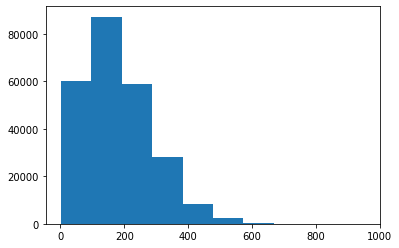

In [17]:
plt.hist(lane_num)

In [194]:
## unequivariant result
with open('./results/ctsconv_map2_predictions.pickle', 'rb') as f:
    unequi_pred = pickle.load(f)

In [197]:
unequi_result = {}
unequi_de = {}

for k, v in unequi_pred.items():
    unequi_de[k] = torch.sqrt((v[0][:,0] - v[1][:,0])**2 + 
                    (v[0][:,1] - v[1][:,1])**2)
    
unequi_ade = []
unequi_de1s = []
unequi_de2s = []
unequi_de3s = []
for k, v in unequi_de.items():
    unequi_ade.append((k, np.mean(v.numpy())))
    unequi_de1s.append((k, v.numpy()[9]))
    unequi_de2s.append((k, v.numpy()[19]))
    unequi_de3s.append((k, v.numpy()[-1]))

In [158]:
de1 = pd.DataFrame(unequi_de1s, columns=['index', 'de1']).de1.mean()
de2 = pd.DataFrame(unequi_de2s, columns=['index', 'de2']).de2.mean()
de3 = pd.DataFrame(unequi_de3s, columns=['index', 'de3']).de3.mean()
de1, de2, de3

(0.9854603948542352, 2.4225305735427436, 4.321105121087632)

In [110]:
df = pd.DataFrame(unequi_de3s, columns=['index', 'de3'])
df.loc[np.argmax(df.de3)], df.loc[np.argmin(df.de3)]

(index    5555.000000
 de3        53.478256
 Name: 29075, dtype: float64,
 index    25410.00000
 de3          0.00816
 Name: 13577, dtype: float64)

(0, 9000)

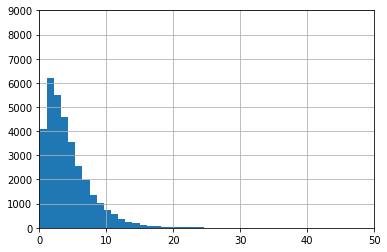

In [111]:
df.de3.hist(bins=50)
plt.xlim(0,50)
plt.ylim(0,9000)

In [195]:
## equivariant result
with open('./results/rho1_ctsconv_map_predictions.pickle', 'rb') as f:
    equi_pred = pickle.load(f)

In [196]:
equi_result = {}
equi_de = {}

for k, v in equi_pred.items():
    equi_de[k] = torch.sqrt((v[0][:,0] - v[1][:,0])**2 + 
                    (v[0][:,1] - v[1][:,1])**2)
    
equi_ade = []
equi_de1s = []
equi_de2s = []
equi_de3s = []
for k, v in equi_de.items():
    equi_ade.append((k, np.mean(v.numpy())))
    equi_de1s.append((k, v.numpy()[9]))
    equi_de2s.append((k, v.numpy()[19]))
    equi_de3s.append((k, v.numpy()[-1]))

In [164]:
de1 = pd.DataFrame(equi_de1s, columns=['index', 'de1']).de1.mean()
de2 = pd.DataFrame(equi_de2s, columns=['index', 'de2']).de2.mean()
de3 = pd.DataFrame(equi_de3s, columns=['index', 'de3']).de3.mean()
de1, de2, de3

(1.015660459864939, 2.4178063363647104, 4.159662730846895)

In [108]:
df = pd.DataFrame(equi_de3s, columns=['index', 'de3'])
df.loc[np.argmax(df.de3)], df.loc[np.argmin(df.de3)]

(index    13330.000000
 de3         50.132324
 Name: 1684, dtype: float64,
 index    34082.0000
 de3          0.0036
 Name: 22162, dtype: float64)

(0, 9000)

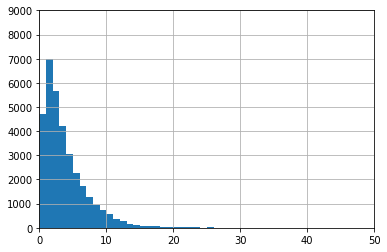

In [109]:
df.de3.hist(bins=50)
plt.xlim(0,50)
plt.ylim(0,9000)

In [19]:
## equivariant result
with open('./results/reg__ctsconv_map_predictions.pickle', 'rb') as f:
    reg_pred = pickle.load(f)

In [20]:
reg_result = {}
reg_de = {}

for k, v in reg_pred.items():
    reg_de[k] = torch.sqrt((v[0][:,0] - v[1][:,0])**2 + 
                    (v[0][:,1] - v[1][:,1])**2)
    
reg_ade = []
reg_de1s = []
reg_de2s = []
reg_de3s = []
for k, v in reg_de.items():
    reg_ade.append((k, np.mean(v.numpy())))
    reg_de1s.append((k, v.numpy()[9]))
    reg_de2s.append((k, v.numpy()[19]))
    reg_de3s.append((k, v.numpy()[-1]))

In [21]:
de1 = pd.DataFrame(reg_de1s, columns=['index', 'de1']).de1.mean()
de2 = pd.DataFrame(reg_de2s, columns=['index', 'de2']).de2.mean()
de3 = pd.DataFrame(reg_de3s, columns=['index', 'de3']).de3.mean()
de1, de2, de3

(0.8927475248333333, 2.1206912216065703, 3.681242375321981)

In [105]:
df = pd.DataFrame(reg_de3s, columns=['index', 'de3'])
df.loc[np.argmax(df.de3)], df.loc[np.argmin(df.de3)]

(index    5555.000000
 de3        59.448654
 Name: 29075, dtype: float64,
 index    15033.000000
 de3          0.005951
 Name: 3355, dtype: float64)

In [171]:
## equivariant result
with open('./results/ctsconv_dense_lstm_predictions.pickle', 'rb') as f:
    other_pred = pickle.load(f)

In [172]:
other_result = {}
other_de = {}

for k, v in other_pred.items():
    other_de[k] = torch.sqrt((v[0][:,0] - v[1][:,0])**2 + 
                    (v[0][:,1] - v[1][:,1])**2)
    
other_ade = []
other_de1s = []
other_de2s = []
other_de3s = []
for k, v in other_de.items():
    other_ade.append((k, np.mean(v.numpy())))
    other_de1s.append((k, v.numpy()[9]))
    other_de2s.append((k, v.numpy()[19]))
    other_de3s.append((k, v.numpy()[-1]))

In [173]:
de1 = pd.DataFrame(other_de1s, columns=['index', 'de1']).de1.mean()
de2 = pd.DataFrame(other_de2s, columns=['index', 'de2']).de2.mean()
de3 = pd.DataFrame(other_de3s, columns=['index', 'de3']).de3.mean()
de1, de2, de3

(1.0293585520323576, 2.4629820659883612, 4.25542642739709)

(0, 9000)

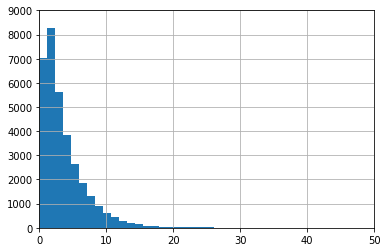

In [106]:
df.de3.hist(bins=50)
plt.xlim(0,50)
plt.ylim(0,9000)

In [77]:
df[df.de3 > 30]

,index,de3
699,13330,50.502350
1613,1437,36.068924
3894,16511,37.197666
5108,17738,36.795242
6748,19370,39.156494
8292,20898,41.621197
8528,21136,39.012199
10037,22646,35.633965
17873,30416,42.228703
19058,31569,43.251583


In [436]:
better_list = []
unequi_dict = {k: v for k,v in unequi_de3s}
reg_dict = {k: v for k,v in reg_de3s}
for k, v in equi_de3s:
    if (unequi_dict[k] > 6) & (v<3) & (reg_dict[k]<1):
        better_list.append(k)
better_631 = better_list

In [437]:
set(better_631).difference(better_511)

{339,
 1431,
 4739,
 6599,
 7977,
 8052,
 9149,
 11677,
 11722,
 12373,
 13571,
 13659,
 13738,
 15367,
 16875,
 17753,
 18396,
 18950,
 19966,
 20378,
 21392,
 22537,
 23526,
 23557,
 24043,
 24477,
 24804,
 25365,
 26289,
 30670,
 31789,
 32502,
 33731,
 34549,
 38313,
 38361,
 39049,
 39302}

In [643]:
def construct_df(pos, track_id, agent_id, city):
    obj_type = np.array(['OTHERS'] * len(pos))
    obj_type[track_id == agent_id] = 'AGENT'
    df = pd.DataFrame(data = {'TRACK_ID': track_id.tolist(), 
                              'X': pos[:,0], 
                              'Y': pos[:,1], 
                              'OBJECT_TYPE': obj_type, 
                              'CITY_NAME': city})
    return df

def visualize_trajectory(
    df: pd.DataFrame, lane_centerlines: Optional[np.ndarray] = None, show: bool = True, smoothen: bool = False, 
    gt = True
) -> None:

    # Seq data
    # time_list = np.sort(np.unique(df["TIMESTAMP"].values))
    city_name = df["CITY_NAME"].values[0]

    lane_centerlines = helper.get_lanes(df, city_name) if lane_centerlines is None else lane_centerlines

    plt.figure(0, figsize=(8, 7))

    x_min = min(df["X"])
    x_max = max(df["X"])
    y_min = min(df["Y"])
    y_max = max(df["Y"])
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)


    for lane_cl in lane_centerlines:
        plt.plot(lane_cl[:, 0], lane_cl[:, 1], "-", color="darkgrey", alpha=1, linewidth=1, zorder=0)
    frames = df.groupby("TRACK_ID")

    # plt.xlabel("Map X")
    # plt.ylabel("Map Y")

    color_dict = {"AGENT": "#d33e4c", "OTHERS": "deepskyblue", "AV": "deepskyblue"}
    object_type_tracker: Dict[int, int] = defaultdict(int)

    # Plot all the tracks up till current frame
    for group_name, group_data in frames:
        object_type = group_data["OBJECT_TYPE"].values[0]

        cor_x = group_data["X"].values
        cor_y = group_data["Y"].values

        if smoothen:
            polyline = np.column_stack((cor_x, cor_y))
            num_points = cor_x.shape[0] * 3
            smooth_polyline = interpolate_polyline(polyline, num_points)
            cor_x = smooth_polyline[:, 0]
            cor_y = smooth_polyline[:, 1]

        plt.plot(
            cor_x[:19],
            cor_y[:19],
            "--",
            color=color_dict[object_type],
            label="History",
            alpha=1,
            linewidth=1,
            zorder=_ZORDER[object_type],
        )
        plt.plot(
            cor_x[19:],
            cor_y[19:],
            "-",
            color=color_dict[object_type],
            label="Ground Truth" if gt else "Prediction",
            alpha=1,
            linewidth=1,
            zorder=_ZORDER[object_type],
        )

        final_x = cor_x[-1]
        final_y = cor_y[-1]

        if object_type == "AGENT":
            marker_type = "o"
            marker_size = 7
        elif object_type == "OTHERS":
            marker_type = "o"
            marker_size = 7
        elif object_type == "AV":
            marker_type = "o"
            marker_size = 7

        plt.plot(
            final_x,
            final_y,
            marker_type,
            color=color_dict[object_type],
            label='Agent' if object_type == "AGENT" else 'Others',
            alpha=1,
            markersize=marker_size,
            zorder=_ZORDER[object_type],
        )

        object_type_tracker[object_type] += 1

    red_star = mlines.Line2D([], [], color="red", marker="*", linestyle="None", markersize=7, label="Agent")
    green_circle = mlines.Line2D([], [], color="green", marker="o", linestyle="None", markersize=7, label="Others")
    black_triangle = mlines.Line2D([], [], color="black", marker="^", linestyle="None", markersize=7, label="AV")

    #plt.axis("off")
    
    if show:
        plt.show()

## prediction

In [18]:
for data_true in val_dataset:
    if data_true['scene_idx'][0] == 6599:
        break
    else:
        pass
data_true['scene_idx'][0]

NameError: name 'data_true' is not defined

In [636]:
## Good ones: 11665
# Rotate good: 14517
# Rotate normal: 14819

### unequivariant

In [637]:
def unequi_pred(data_true):
    data0 = data_true
    lane = data0['lane'][0]
    lane_normals = data0['lane_norm'][0]
    agent_id = data0['agent_id'][0]
    city = data0['city'][0]
    mask = data0['car_mask'][0].astype(bool).squeeze(-1)

    prediction = construct_df(data0['pos_2s'][0][mask,0], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0])
    for i in range(1,19):
        prediction = prediction.append(construct_df(data0['pos_2s'][0][mask,i], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))
    prediction = prediction.append(construct_df(data0['pos0'][0][mask], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))

    device = torch.device('cuda')
    data = {}
    convert_keys = (['pos' + str(i) for i in range(30)] + 
                    ['vel' + str(i) for i in range(30)] + 
                    ['pos_2s', 'vel_2s', 'lane', 'lane_norm'])

    for k in convert_keys:
        data[k] = torch.tensor(np.stack(data0[k]), dtype=torch.float32, device=device)

    for k in ['track_id' + str(i) for i in range(30)] + ['city', 'agent_id', 'scene_idx']:
        data[k] = np.stack(data0[k])

    for k in ['car_mask', 'lane_mask']:
        data[k] = torch.tensor(np.stack(data0[k]), dtype=torch.float32, device=device)

    scenes = data['scene_idx'].tolist()

    data['agent_id'] = data['agent_id'][:,np.newaxis]

    data['car_mask'] = data['car_mask'].squeeze(-1)
    accel = torch.zeros(1, 1, 3).to(device)
    data['accel'] = accel

    lane = data['lane']
    lane_normals = data['lane_norm']
    agent_id = data['agent_id']
    city = data['city']
    inputs = ([
                data['pos_2s'], data['vel_2s'], 
                data['pos0'], data['vel0'], 
                data['accel'], None,
                data['lane'], data['lane_norm'], 
                data['car_mask'], data['lane_mask']
            ])
    
    with torch.no_grad():
        pr_pos1, pr_vel1, states = model_unequi(inputs)

        prediction = prediction.append(construct_df(pr_pos1.cpu().numpy()[0,mask], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))

        pos0, vel0 = data['pos0'], data['vel0']
        for i in range(29):
            # print("i: " + str(i) + ' .... ', end='')
            pos_enc = torch.unsqueeze(pos0, 2)
            # pos_2s = torch.cat([pos_2s[:,:,1:,:], pos_enc], axis=2)
            vel_enc = torch.unsqueeze(vel0, 2)
            # vel_2s = torch.cat([vel_2s[:,:,1:,:], vel_enc], axis=2)
            inputs = (pos_enc, vel_enc, pr_pos1, pr_vel1, data['accel'], None, 
                      data['lane'], data['lane_norm'], data['car_mask'], data['lane_mask'])
            pos0, vel0 = pr_pos1, pr_vel1
            pr_pos1, pr_vel1, states = model_unequi(inputs, states)
            prediction = prediction.append(construct_df(pr_pos1.cpu().numpy()[0,mask], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))
            # print('DONE')
    return prediction

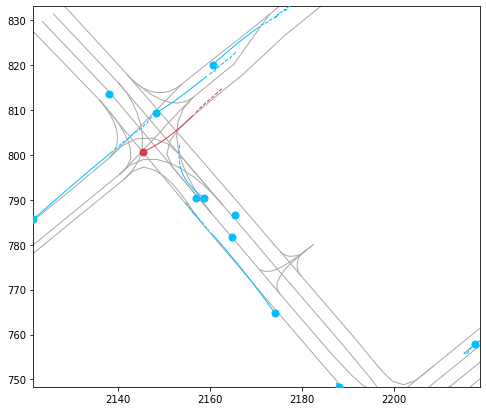

In [753]:
prediction = unequi_pred(data_true)
visualize_trajectory(prediction, show=False)
plt.savefig('figs/unequi_normal.pdf')

### equivariant

In [293]:
def equi_pred(data_true):
    data0 = data_true
    lane = data0['lane'][0]
    lane_normals = data0['lane_norm'][0]
    agent_id = data0['agent_id'][0]
    city = data0['city'][0]
    mask = data0['car_mask'][0].astype(bool).squeeze(-1)

    prediction0 = construct_df(data0['pos_2s'][0][mask,0], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0])
    for i in range(1,19):
        prediction0 = prediction0.append(construct_df(data0['pos_2s'][0][mask,i], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))
    prediction0 = prediction0.append(construct_df(data0['pos0'][0][mask], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))

    device = torch.device('cuda')
    data = {}
    convert_keys = (['pos' + str(i) for i in range(30)] + 
                    ['vel' + str(i) for i in range(30)] + 
                    ['pos_2s', 'vel_2s', 'lane', 'lane_norm'])

    for k in convert_keys:
        data[k] = torch.tensor(np.stack(data0[k])[...,:2], dtype=torch.float32, device=device)

    for k in ['track_id' + str(i) for i in range(30)] + ['city', 'agent_id', 'scene_idx']:
        data[k] = np.stack(data0[k])

    for k in ['car_mask', 'lane_mask']:
        data[k] = torch.tensor(np.stack(data0[k]), dtype=torch.float32, device=device).unsqueeze(-1)

    scenes = data['scene_idx'].tolist()

    data['agent_id'] = data['agent_id'][:,np.newaxis]

    data['car_mask'] = data['car_mask'].squeeze(-1)
    accel = torch.zeros(1, 1, 2).to(device)
    data['accel'] = accel

    lane = data['lane']
    lane_normals = data['lane_norm']
    agent_id = data['agent_id']
    city = data['city']
    inputs = ([
                data['pos_2s'], data['vel_2s'], 
                data['pos0'], data['vel0'], 
                data['accel'], None,
                data['lane'], data['lane_norm'], 
                data['car_mask'], data['lane_mask']
            ])
    
    model_equi.eval()
    with torch.no_grad():
        pr_pos1, pr_vel1, states = model_equi(inputs)

        prediction0 = prediction0.append(construct_df(pr_pos1.cpu().numpy()[0,mask], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))

        pos0, vel0 = data['pos0'], data['vel0']
        for i in range(29):
            # print("i: " + str(i) + ' .... ', end='')
            pos_enc = torch.unsqueeze(pos0, 2)
            # pos_2s = torch.cat([pos_2s[:,:,1:,:], pos_enc], axis=2)
            vel_enc = torch.unsqueeze(vel0, 2)
            # vel_2s = torch.cat([vel_2s[:,:,1:,:], vel_enc], axis=2)
            inputs = (pos_enc, vel_enc, pr_pos1, pr_vel1, data['accel'], None, 
                      data['lane'], data['lane_norm'], data['car_mask'], data['lane_mask'])
            pos0, vel0 = pr_pos1, pr_vel1
            pr_pos1, pr_vel1, states = model_equi(inputs, states)
            prediction0 = prediction0.append(construct_df(pr_pos1.cpu().numpy()[0,mask], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))
            # print('DONE')
    return prediction0

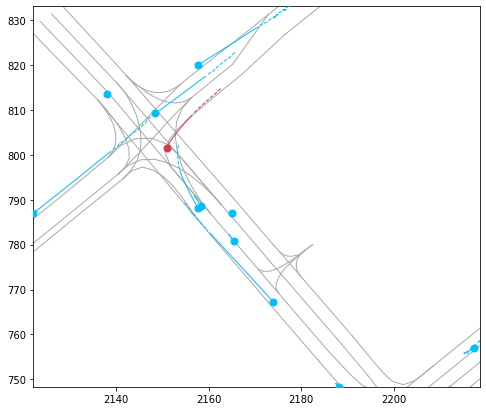

In [754]:
prediction0 = equi_pred(data_true)
visualize_trajectory(prediction0, show=False)
plt.savefig('figs/rho1_normal.pdf')

### reg equi

In [295]:
def reg_pred(data_true):
    data0 = data_true
    lane = data0['lane'][0]
    lane_normals = data0['lane_norm'][0]
    agent_id = data0['agent_id'][0]
    city = data0['city'][0]
    mask = data0['car_mask'][0].astype(bool).squeeze(-1)

    prediction0 = construct_df(data0['pos_2s'][0][mask,0], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0])
    for i in range(1,19):
        prediction0 = prediction0.append(construct_df(data0['pos_2s'][0][mask,i], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))
    prediction0 = prediction0.append(construct_df(data0['pos0'][0][mask], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))

    device = torch.device('cuda')
    data = {}
    convert_keys = (['pos' + str(i) for i in range(30)] + 
                    ['vel' + str(i) for i in range(30)] + 
                    ['pos_2s', 'vel_2s', 'lane', 'lane_norm'])

    for k in convert_keys:
        data[k] = torch.tensor(np.stack(data0[k])[...,:2], dtype=torch.float32, device=device)

    for k in ['track_id' + str(i) for i in range(30)] + ['city', 'agent_id', 'scene_idx']:
        data[k] = np.stack(data0[k])

    for k in ['car_mask', 'lane_mask']:
        data[k] = torch.tensor(np.stack(data0[k]), dtype=torch.float32, device=device).unsqueeze(-1)

    scenes = data['scene_idx'].tolist()

    data['agent_id'] = data['agent_id'][:,np.newaxis]

    data['car_mask'] = data['car_mask'].squeeze(-1)
    accel = torch.zeros(1, 1, 2).to(device)
    data['accel'] = accel

    lane = data['lane']
    lane_normals = data['lane_norm']
    agent_id = data['agent_id']
    city = data['city']
    inputs = ([
                data['pos_2s'], data['vel_2s'], 
                data['pos0'], data['vel0'], 
                data['accel'], None,
                data['lane'], data['lane_norm'], 
                data['car_mask'], data['lane_mask']
            ])
    
    model_reg.eval()
    with torch.no_grad():
        pr_pos1, pr_vel1, states = model_reg(inputs)

        prediction0 = prediction0.append(construct_df(pr_pos1.cpu().numpy()[0,mask], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))

        pos0, vel0 = data['pos0'], data['vel0']
        for i in range(29):
            # print("i: " + str(i) + ' .... ', end='')
            pos_enc = torch.unsqueeze(pos0, 2)
            # pos_2s = torch.cat([pos_2s[:,:,1:,:], pos_enc], axis=2)
            vel_enc = torch.unsqueeze(vel0, 2)
            # vel_2s = torch.cat([vel_2s[:,:,1:,:], vel_enc], axis=2)
            inputs = (pos_enc, vel_enc, pr_pos1, pr_vel1, data['accel'], None, 
                      data['lane'], data['lane_norm'], data['car_mask'], data['lane_mask'])
            pos0, vel0 = pr_pos1, pr_vel1
            pr_pos1, pr_vel1, states = model_reg(inputs, states)
            prediction0 = prediction0.append(construct_df(pr_pos1.cpu().numpy()[0,mask], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))
            # print('DONE')
    return prediction0

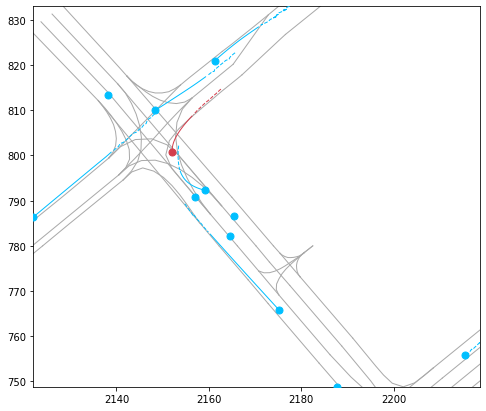

In [755]:
prediction1 = reg_pred(data_true)
visualize_trajectory(prediction1, show=False)
plt.savefig('figs/reg_normal.pdf')

#### step by step

In [75]:
data0 = data_true
lane = data0['lane'][0]
lane_normals = data0['lane_norm'][0]
agent_id = data0['agent_id'][0]
city = data0['city'][0]
mask = data0['car_mask'][0].astype(bool).squeeze(-1)
data0['lane_mask'] = [np.array([0])]

prediction0 = construct_df(data0['pos_2s'][0][mask,0], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0])
for i in range(1,19):
    prediction0 = prediction0.append(construct_df(data0['pos_2s'][0][mask,i], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))
prediction0 = prediction0.append(construct_df(data0['pos0'][0][mask], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))

In [77]:
device = torch.device('cuda')
data = {}
convert_keys = (['pos' + str(i) for i in range(30)] + 
                ['vel' + str(i) for i in range(30)] + 
                ['pos_2s', 'vel_2s', 'lane', 'lane_norm'])

for k in convert_keys:
    data[k] = torch.tensor(np.stack(data0[k])[...,:2], dtype=torch.float32, device=device)

for k in ['track_id' + str(i) for i in range(30)] + ['city', 'agent_id', 'scene_idx']:
    data[k] = np.stack(data0[k])

for k in ['car_mask', 'lane_mask']:
    data[k] = torch.tensor(np.stack(data0[k]), dtype=torch.float32, device=device).unsqueeze(-1)

scenes = data['scene_idx'].tolist()

data['agent_id'] = data['agent_id'][:,np.newaxis]

data['car_mask'] = data['car_mask'].squeeze(-1)
accel = torch.zeros(1, 1, 2).to(device)
data['accel'] = accel

lane = data['lane']
lane_normals = data['lane_norm']
agent_id = data['agent_id']
city = data['city']
inputs = ([
            data['pos_2s'], data['vel_2s'], 
            data['pos0'], data['vel0'], 
            data['accel'], None,
            data['lane'], data['lane_norm'], 
            data['car_mask'], data['lane_mask']
        ])


In [78]:
model_equi.eval()
with torch.no_grad():
    pr_pos1, pr_vel1, states = model_equi(inputs)

    prediction0 = prediction0.append(construct_df(pr_pos1.cpu().numpy()[0,mask], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))

    pos0, vel0 = data['pos0'], data['vel0']
    for i in range(29):
        print("i: " + str(i) + ' .... ', end='')
        pos_enc = torch.unsqueeze(pos0, 2)
        # pos_2s = torch.cat([pos_2s[:,:,1:,:], pos_enc], axis=2)
        vel_enc = torch.unsqueeze(vel0, 2)
        # vel_2s = torch.cat([vel_2s[:,:,1:,:], vel_enc], axis=2)
        inputs = (pos_enc, vel_enc, pr_pos1, pr_vel1, data['accel'], None, 
                  data['lane'], data['lane_norm'], data['car_mask'], data['lane_mask'])
        pos0, vel0 = pr_pos1, pr_vel1
        pr_pos1, pr_vel1, states = model_equi(inputs, states)
        prediction0 = prediction0.append(construct_df(pr_pos1.cpu().numpy()[0,mask], data0['track_id0'][0][mask], data0['agent_id'][0], data0['city'][0]))
        print('DONE')

i: 0 .... DONE
i: 1 .... DONE
i: 2 .... DONE
i: 3 .... DONE
i: 4 .... DONE
i: 5 .... DONE
i: 6 .... DONE
i: 7 .... DONE
i: 8 .... DONE
i: 9 .... DONE
i: 10 .... DONE
i: 11 .... DONE
i: 12 .... DONE
i: 13 .... DONE
i: 14 .... DONE
i: 15 .... DONE
i: 16 .... DONE
i: 17 .... DONE
i: 18 .... DONE
i: 19 .... DONE
i: 20 .... DONE
i: 21 .... DONE
i: 22 .... DONE
i: 23 .... DONE
i: 24 .... DONE
i: 25 .... DONE
i: 26 .... DONE
i: 27 .... DONE
i: 28 .... DONE


In [79]:
prediction0[prediction0.OBJECT_TYPE == 'AGENT']

,TRACK_ID,X,Y,OBJECT_TYPE,CITY_NAME
10,00000000-0000-0000-0000-000000005613,2144.732422,805.530762,AGENT,PIT
10,00000000-0000-0000-0000-000000005613,2145.204834,804.949097,AGENT,PIT
10,00000000-0000-0000-0000-000000005613,2146.079102,803.930603,AGENT,PIT
10,00000000-0000-0000-0000-000000005613,2147.199951,802.740051,AGENT,PIT
10,00000000-0000-0000-0000-000000005613,2147.676270,802.151550,AGENT,PIT
10,00000000-0000-0000-0000-000000005613,2148.715820,800.897217,AGENT,PIT
10,00000000-0000-0000-0000-000000005613,2149.329590,800.276367,AGENT,PIT
10,00000000-0000-0000-0000-000000005613,2150.434082,798.936218,AGENT,PIT
10,00000000-0000-0000-0000-000000005613,2151.594482,797.528564,AGENT,PIT
10,00000000-0000-0000-0000-000000005613,2152.891602,796.057861,AGENT,PIT


### ground true

In [190]:
_ZORDER = {"AGENT": 15, "AV": 10, "OTHERS": 5}
def visualize_trajectory(
    df: pd.DataFrame, lane_centerlines= None, show: bool = True, smoothen: bool = False
) -> None:

    # Seq data
    # time_list = np.sort(np.unique(df["TIMESTAMP"].values))
    city_name = df["CITY_NAME"].values[0]

    lane_centerlines = helper.get_lanes(df, city_name) if lane_centerlines is None else lane_centerlines

    plt.figure(0, figsize=(8, 7))

    x_min = min(df["X"])
    x_max = max(df["X"])
    y_min = min(df["Y"])
    y_max = max(df["Y"])
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)


    for lane_cl in lane_centerlines:
        plt.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)
    frames = df.groupby("TRACK_ID")

    plt.xlabel("Map X")
    plt.ylabel("Map Y")

    color_dict = {"AGENT": "#d33e4c", "OTHERS": "#13d4f2", "AV": "#007672"}
    object_type_tracker: Dict[int, int] = defaultdict(int)

    # Plot all the tracks up till current frame
    for group_name, group_data in frames:
        object_type = group_data["OBJECT_TYPE"].values[0]

        cor_x = group_data["X"].values
        cor_y = group_data["Y"].values

        if smoothen:
            polyline = np.column_stack((cor_x, cor_y))
            num_points = cor_x.shape[0] * 3
            smooth_polyline = interpolate_polyline(polyline, num_points)
            cor_x = smooth_polyline[:, 0]
            cor_y = smooth_polyline[:, 1]

        plt.plot(
            cor_x,
            cor_y,
            "-",
            color=color_dict[object_type],
            label=object_type if not object_type_tracker[object_type] else "",
            alpha=1,
            linewidth=1,
            zorder=_ZORDER[object_type],
        )

        final_x = cor_x[-1]
        final_y = cor_y[-1]

        if object_type == "AGENT":
            marker_type = "o"
            marker_size = 7
        elif object_type == "OTHERS":
            marker_type = "o"
            marker_size = 7
        elif object_type == "AV":
            marker_type = "o"
            marker_size = 7

        plt.plot(
            final_x,
            final_y,
            marker_type,
            color=color_dict[object_type],
            label=object_type if not object_type_tracker[object_type] else "",
            alpha=1,
            markersize=marker_size,
            zorder=_ZORDER[object_type],
        )

        object_type_tracker[object_type] += 1

    red_star = mlines.Line2D([], [], color="red", marker="*", linestyle="None", markersize=7, label="Agent")
    green_circle = mlines.Line2D([], [], color="green", marker="o", linestyle="None", markersize=7, label="Others")
    black_triangle = mlines.Line2D([], [], color="black", marker="^", linestyle="None", markersize=7, label="AV")

    plt.axis("off")
    
    if show:
        plt.show()



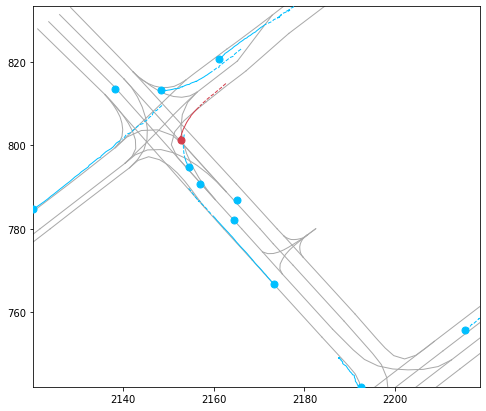

In [756]:
data = afl[data_true['scene_idx'][0]].seq_df
visualize_trajectory(data[data.TRACK_ID.isin(data_true['track_id0'][0])], show=False)
plt.savefig('figs/gt_normal.pdf')

In [582]:
plt.legend?

In [132]:
def __expand_df_generator(df, city_name):
    ids = df.TRACK_ID.unique()
    tstmps = df.TIMESTAMP.unique()
    for tstmp, sub_df in df.groupby('TIMESTAMP'):
        for idx in ids:
            if not idx in sub_df.TRACK_ID.values:
                yield pd.DataFrame(dict(TIMESTAMP = [tstmp], TRACK_ID = [idx], X = [np.nan], Y = [np.nan], 
                                   CITY_NAME = [city_name], 
                                        OBJECT_TYPE = [df[df['TRACK_ID'] == idx]['OBJECT_TYPE'].iloc[0]]))
            else:
                yield df[(df['TIMESTAMP'] == tstmp) & (df['TRACK_ID'] == idx)]

def _expand_df(df, city_name):
    return pd.concat(__expand_df_generator(df, city_name), axis=0)

def _linear_interpolate_generator(data, col=['X', 'Y']):
        for idx, df in data.groupby('TRACK_ID'):
            sub_df = df.copy()
            sub_df[col] = sub_df[col].interpolate(limit_direction='both')
            yield sub_df
    
def _linear_interpolate(data, col=['X', 'Y']):
    return pd.concat(_linear_interpolate_generator(data, col), axis=0)

t = 1, 2, 3, 4, 5, 6
d   p1, , , p4, p5, , ,

In [134]:
date_int = _linear_interpolate(_expand_df(data, data.CITY_NAME[0]))

In [135]:
for t in date_int.TIMESTAMP.unique():
    print(t, len(date_int[date_int['TIMESTAMP'] == t]))

315968038.89604795 38
315968039.04043096 38
315968039.17683005 38
315968039.33288604 38
315968039.46789265 38
315968039.6069792 38
315968039.7371366 38
315968039.8592167 38
315968039.9824077 38
315968040.1053416 38
315968040.2279925 38
315968040.50220466 38
315968040.8722797 38
315968041.1312101 38
315968041.4024748 38
315968041.6500637 38
315968041.90709263 38
315968042.1602027 38
315968042.3965527 38
315968042.6506274 38
315968042.89273936 38
315968043.2465368 38
315968043.67842585 38
315968043.8586004 38
315968044.0356741 38
315968044.1918096 38
315968044.3524167 38
315968044.5100026 38
315968044.78520715 38
315968045.03072137 38
315968045.30171186 38
315968045.55127764 38
315968045.732921 38
315968045.89711654 38
315968046.05140764 38
315968046.23077786 38
315968046.3961283 38
315968046.5622395 38
315968046.7242573 38
315968046.8987609 38
315968047.05832684 38
315968047.0819527 38
315968047.1745593 38
315968047.27892727 38
315968047.3791668 38
315968047.4762078 38
315968047.5782195

### Rotation Experiment

In [648]:
def RotMat(theta):
    m = np.array([
            [np.cos(theta), -np.sin(theta)], 
            [np.sin(theta), np.cos(theta)]
        ])
    return m

def rotation(theta, field):
    rotmat = RotMat(theta)
    rot_field = np.zeros(field.shape)
    rot_field[...,:2] =  np.einsum('ij,...j->...i', rotmat, field[...,:2])
    if field.shape[-1] > 2:
        rot_field[...,2] = 0
    return rot_field

def rot_visualize(
    df, rotdf, theta, lane_centerlines = None, show: bool = True, smoothen: bool = False, 
    gt=False
) -> None:
    
    _ZORDER = {"AGENT": 15, "AV": 10, "OTHERS": 5}
    
    # Seq data
    # time_list = np.sort(np.unique(df["TIMESTAMP"].values))
    city_name = df["CITY_NAME"].values[0]

    lane_centerlines = helper.get_lanes(df, city_name) if lane_centerlines is None else lane_centerlines
    lane_centerlines = [rotation(theta, l) for l in lane_centerlines]

    plt.figure(0, figsize=(8, 7))

    x_min = min(rotdf["X"])
    x_max = max(rotdf["X"])
    y_min = min(rotdf["Y"])
    y_max = max(rotdf["Y"])
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)


    for lane_cl in lane_centerlines:
        plt.plot(lane_cl[:, 0], lane_cl[:, 1], "-", color="grey", alpha=1, linewidth=1, zorder=0)
    frames = rotdf.groupby("TRACK_ID")

    # plt.xlabel("Map X")
    # plt.ylabel("Map Y")
    
    color_dict = {"AGENT": "#d33e4c", "OTHERS": "deepskyblue", "AV": "deepskyblue"}
    object_type_tracker: Dict[int, int] = defaultdict(int)

    # Plot all the tracks up till current frame
    for group_name, group_data in frames:
        object_type = group_data["OBJECT_TYPE"].values[0]

        cor_x = group_data["X"].values
        cor_y = group_data["Y"].values

        if smoothen:
            polyline = np.column_stack((cor_x, cor_y))
            num_points = cor_x.shape[0] * 3
            smooth_polyline = interpolate_polyline(polyline, num_points)
            cor_x = smooth_polyline[:, 0]
            cor_y = smooth_polyline[:, 1]

        plt.plot(
            cor_x[:19],
            cor_y[:19],
            "--",
            color=color_dict[object_type],
            label="History",
            alpha=1,
            linewidth=1,
            zorder=_ZORDER[object_type],
        )
        plt.plot(
            cor_x[19:],
            cor_y[19:],
            "-",
            color=color_dict[object_type],
            label="Ground Truth" if gt else "Prediction",
            alpha=1,
            linewidth=1,
            zorder=_ZORDER[object_type],
        )

        final_x = cor_x[-1]
        final_y = cor_y[-1]

        if object_type == "AGENT":
            marker_type = "o"
            marker_size = 7
        elif object_type == "OTHERS":
            marker_type = "o"
            marker_size = 7
        elif object_type == "AV":
            marker_type = "o"
            marker_size = 7

        plt.plot(
            final_x,
            final_y,
            marker_type,
            color=color_dict[object_type],
            label=object_type if not object_type_tracker[object_type] else "",
            alpha=1,
            markersize=marker_size,
            zorder=_ZORDER[object_type],
        )

        object_type_tracker[object_type] += 1

    red_star = mlines.Line2D([], [], color="red", marker="*", linestyle="None", markersize=7, label="Agent")
    green_circle = mlines.Line2D([], [], color="green", marker="o", linestyle="None", markersize=7, label="Others")
    black_triangle = mlines.Line2D([], [], color="black", marker="^", linestyle="None", markersize=7, label="AV")

    # plt.axis("off")
    
    if show:
        plt.show()

In [589]:
theta = 7*np.pi/8
convert_keys = (['pos' + str(i) for i in range(30)] + 
                ['vel' + str(i) for i in range(30)] + 
                ['pos_2s', 'vel_2s', 'lane', 'lane_norm'])
rotate_data = data_true.copy()
for k in convert_keys:
    rotate_data[k] = [rotation(theta, rotate_data[k][0])]

In [590]:
rot_prediction = unequi_pred(rotate_data)

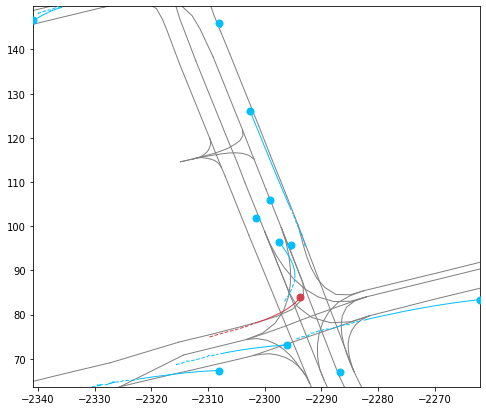

In [757]:
rot_visualize(prediction, rot_prediction, theta, show=False)
plt.savefig('figs/unequi_rot.pdf')

In [594]:
rot_prediction0 = equi_pred(rotate_data)

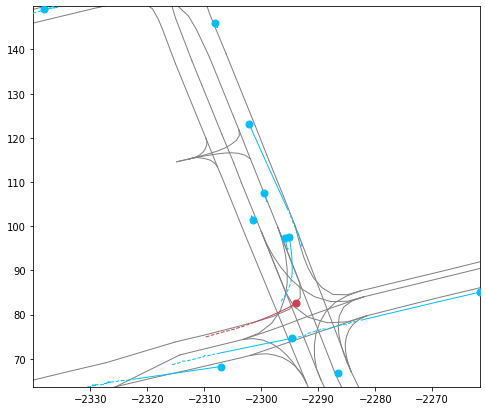

In [758]:
rot_visualize(prediction0, rot_prediction0, theta, show=False)
plt.savefig('figs/rho1_rot.pdf')

In [596]:
rot_prediction1 = reg_pred(rotate_data)

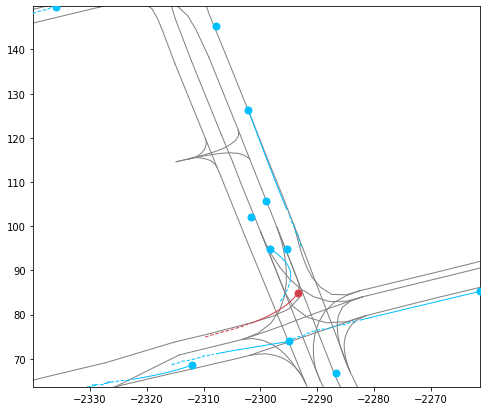

In [759]:
rot_visualize(prediction1, rot_prediction1, theta, show=False)
plt.savefig('figs/reg_rot.pdf')

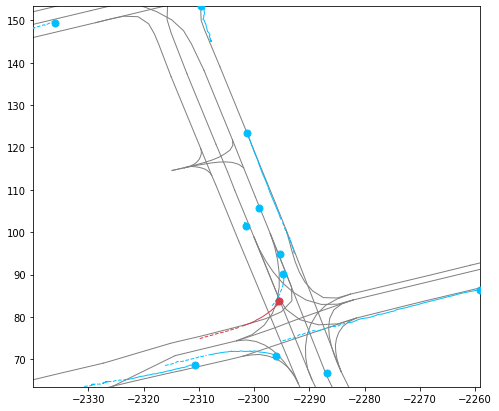

In [760]:
data = afl[data_true['scene_idx'][0]].seq_df
data = data[data.TRACK_ID.isin(data_true['track_id0'][0])]
rot_data = data.copy()
rot_data[['X', 'Y']] = rotation(theta, rot_data[['X', 'Y']].values)
rot_visualize(data, rot_data, theta, show=False)
plt.savefig('figs/gt_rot.pdf')

In [761]:
!zip -q -r figs.zip figs

## Learning Curve

In [17]:
total_result = pd.DataFrame()

In [656]:
def get_result(prediction_gt):
    result = {}
    de = {}
    # return total_loss, prediction_gt
    
    for k, v in prediction_gt.items():
        de[k] = torch.sqrt((v[0][:,0] - v[1][:,0])**2 + 
                        (v[0][:,1] - v[1][:,1])**2)
        
    ade = []
    de1s = []
    de2s = []
    de3s = []
    for k, v in de.items():
        ade.append(np.mean(v.numpy()))
        de1s.append(v.numpy()[9])
        de2s.append(v.numpy()[19])
        de3s.append(v.numpy()[-1])
    
    result['ADE'] = np.mean(ade)
    result['ADE_std'] = np.std(ade)
    result['DE@1s'] = np.mean(de1s)
    result['DE@1s_std'] = np.std(de1s)
    result['DE@2s'] = np.mean(de2s)
    result['DE@2s_std'] = np.std(de2s)
    result['DE@3s'] = np.mean(de3s)
    result['DE@3s_std'] = np.std(de3s)
    return result

### reg rep

In [8]:
with open('results/reg__ctsconv_map_val_metrics.pickle', 'rb') as f:
    reg_val_metrics = pickle.load(f)

In [12]:
reg_result = [get_result(prediction_gt) for prediction_gt in reg_val_metrics]

In [18]:
df = pd.DataFrame(reg_result)[['ADE', 'DE@3s']]
df['Type'] = 'reg rep'
df.reset_index(inplace=True)
df.rename(columns={'index':'epochs'}, inplace=True)
total_result = total_result.append(df)

### rho-1 rep

In [19]:
with open('results/rho1_ctsconv_map_val_metrics.pickle', 'rb') as f:
    rho1_val_metrics = pickle.load(f)

In [20]:
rho1_result = [get_result(prediction_gt) for prediction_gt in rho1_val_metrics]

In [21]:
df = pd.DataFrame(rho1_result)[['ADE', 'DE@3s']]
df['Type'] = 'rho1 rep'
df.reset_index(inplace=True)
df.rename(columns={'index':'epochs'}, inplace=True)
total_result = total_result.append(df)

### rho-1 rep teacher forcing

In [35]:
with open('results/bullseye_unparam_equi_ctsconv_stk_vel_t16_val_metrics.pickle', 'rb') as f:
    rho1_tf_val_metrics = pickle.load(f)

In [36]:
rho1_tf_result = [get_result(prediction_gt) for prediction_gt in rho1_tf_val_metrics]

In [37]:
df = pd.DataFrame(rho1_tf_result)[['ADE', 'DE@3s']]
df['Type'] = 'rho1 rep(teacher forcing)'
df.reset_index(inplace=True)
df.rename(columns={'index':'epochs'}, inplace=True)
total_result = total_result.append(df)

### non-equivariant

In [22]:
with open('results/ctsconv_map2_val_metrics.pickle', 'rb') as f:
    ctsconv_val_metrics = pickle.load(f)

In [23]:
ctsconv_result = [get_result(prediction_gt) for prediction_gt in ctsconv_val_metrics]

In [24]:
df = pd.DataFrame(ctsconv_result)[['ADE', 'DE@3s']]
df['Type'] = 'non-equiv'
df.reset_index(inplace=True)
df.rename(columns={'index':'epochs'}, inplace=True)
total_result = total_result.append(df)

In [75]:
df.rename?

In [27]:
import seaborn as sns

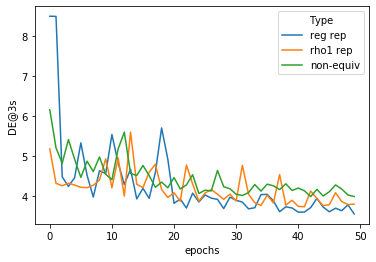

In [28]:
sns.lineplot(data=total_result, x="epochs", y="DE@3s", hue="Type")

## first ten epochs

In [39]:
total_result_10 = pd.DataFrame()

In [46]:
with open('results/reg_ctsconv_first_10_val_metrics.pickle', 'rb') as f:
    reg_val_metrics_1 = pickle.load(f)
reg_result_1 = [get_result(prediction_gt) for prediction_gt in reg_val_metrics_1]
df = pd.DataFrame(reg_result_10)[['ADE', 'DE@3s']]
df['Type'] = 'reg rep'
df.reset_index(inplace=True)
df.rename(columns={'index':'Iterations(*10)'}, inplace=True)
total_result_10 = total_result_10.append(df)

In [47]:
with open('results/ctsconv_10_epochs_val_metrics.pickle', 'rb') as f:
    ctsconv_val_metrics_10 = pickle.load(f)
ctsconv_result_10 = [get_result(prediction_gt) for prediction_gt in ctsconv_val_metrics_10[:275]]
df = pd.DataFrame(ctsconv_result_10)[['ADE', 'DE@3s']]
df['Type'] = 'non equi'
df.reset_index(inplace=True)
df.rename(columns={'index':'Iterations(*10)'}, inplace=True)
total_result_10 = total_result_10.append(df)

In [47]:
with open('results/rho1_ctsconv_first_10_val_metrics.pickle', 'rb') as f:
    rho1_val_metrics_10 = pickle.load(f)
ctsconv_result_10 = [get_result(prediction_gt) for prediction_gt in ctsconv_val_metrics_10[:275]]
df = pd.DataFrame(ctsconv_result_10)[['ADE', 'DE@3s']]
df['Type'] = 'non equi'
df.reset_index(inplace=True)
df.rename(columns={'index':'Iterations(*10)'}, inplace=True)
total_result_10 = total_result_10.append(df)

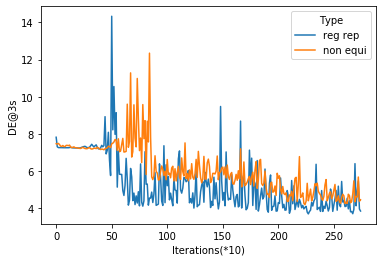

In [48]:
sns.lineplot(data=total_result_10, x="Iterations(*10)", y="DE@3s", hue="Type")

In [657]:
with open('results/reg_ctsconv_first_10_val_metrics.pickle', 'rb') as f:
    reg_val_metrics_1 = pickle.load(f)
reg_result_1 = [get_result(prediction_gt) for prediction_gt in reg_val_metrics_1[:100]]

with open('results/reg_ctsconv_first_10_2_val_metrics.pickle', 'rb') as f:
    reg_val_metrics_2 = pickle.load(f)
reg_result_2 = [get_result(prediction_gt) for prediction_gt in reg_val_metrics_2[:100]]

In [673]:
len(reg_val_metrics_1), len(reg_val_metrics_2)

(275, 100)

In [703]:
reg_de3_1 = pd.DataFrame(reg_result_1)['DE@3s'].values
reg_de3_2 = pd.DataFrame(reg_result_2)['DE@3s'].values
reg_de3 = (reg_de3_1 + reg_de3_2) / 2
reg_std = (reg_de3_1 - reg_de3_2) / 2

In [662]:
with open('results/rho1_ctsconv_first_10_val_metrics.pickle', 'rb') as f:
    rho1_val_metrics_1 = pickle.load(f)
rho1_result_1 = [get_result(prediction_gt) for prediction_gt in rho1_val_metrics_1[:100]]

with open('results/rho1_ctsconv_first_10_2_val_metrics.pickle', 'rb') as f:
    rho1_val_metrics_2 = pickle.load(f)
rho1_result_2 = [get_result(prediction_gt) for prediction_gt in rho1_val_metrics_2[:100]]

In [674]:
len(rho1_val_metrics_1), len(rho1_val_metrics_1)

(109, 109)

In [704]:
rho1_de3_1 = pd.DataFrame(rho1_result_1)['DE@3s'].values
rho1_de3_2 = pd.DataFrame(rho1_result_2)['DE@3s'].values
rho1_de3 = (rho1_de3_1 + rho1_de3_2) / 2
rho1_std = (rho1_de3_1 - rho1_de3_2) / 2

In [664]:
with open('results/ctsconv_10_epochs_val_metrics.pickle', 'rb') as f:
    unequi_val_metrics_1 = pickle.load(f)
unequi_result_1 = [get_result(prediction_gt) for prediction_gt in unequi_val_metrics_1[:100]]

with open('results/ctsconv_first_10_steps_2_val_metrics.pickle', 'rb') as f:
    unequi_val_metrics_2 = pickle.load(f)
unequi_result_2 = [get_result(prediction_gt) for prediction_gt in unequi_val_metrics_2[:100]]

In [675]:
len(reg_val_metrics_1), len(reg_val_metrics_1)

(275, 275)

In [705]:
unequi_de3_1 = pd.DataFrame(unequi_result_1)['DE@3s'].values
unequi_de3_2 = pd.DataFrame(unequi_result_2)['DE@3s'].values
unequi_de3 = (unequi_de3_1 + unequi_de3_2) / 2
unequi_std = (unequi_de3_1 - unequi_de3_2) / 2

In [744]:
w = 5
def moving_average(a, n=w) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [680]:
avg_unequi = moving_average(unequi_de3)

(98,)

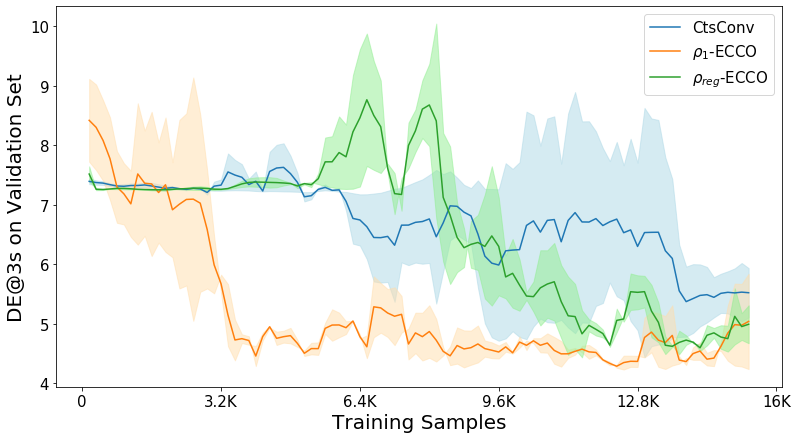

In [752]:
plt.figure(figsize=(13,7))
plt.plot(np.arange(101-w)+1, moving_average(unequi_de3), label='CtsConv')
plt.fill_between(np.arange(101-w)+1, moving_average(unequi_de3) + moving_average(unequi_std), 
                moving_average(unequi_de3) - moving_average(unequi_std), color='lightblue', alpha=0.5)
plt.plot(np.arange(101-w)+1, moving_average(rho1_de3), label=r'$\rho_1$-ECCO')
plt.fill_between(np.arange(101-w)+1, moving_average(rho1_de3) + moving_average(rho1_std), 
                moving_average(rho1_de3) - moving_average(rho1_std), color='navajowhite', alpha=0.5)
plt.plot(np.arange(101-w)+1, moving_average(reg_de3), label=r'$\rho_{reg}$-ECCO')
plt.fill_between(np.arange(101-w)+1, moving_average(reg_de3) + moving_average(reg_std), 
                moving_average(reg_de3) - moving_average(reg_std), color='lightgreen', alpha=0.5)
plt.legend(fontsize=15)
plt.xlabel('Training Samples', fontsize=20)
plt.ylabel('DE@3s on Validation Set', fontsize=20)
plt.xticks([0, 20, 40, 60, 80, 100], [0, '3.2K', '6.4K', '9.6K', '12.8K', '16K'], fontsize=15)
plt.yticks([4,5,6,7,8,9,10], [4,5,6,7,8,9,10], fontsize=15)
plt.savefig('figs/sample-efficiency.pdf')

### Pedestrian result

In [53]:
with open('results/pedestrain_ctsconv_equivariant_val_metrics.pickle', 'rb') as f:
    pedestrain = pickle.load(f)

In [55]:
pedestrain[0]

{'biwi_hotel_104': (tensor([[ 2.7000, -4.7900],
          [ 2.6200, -4.1900],
          [ 2.5400, -3.5900],
          [ 2.4600, -2.9900],
          [ 2.3800, -2.3900],
          [ 2.3000, -1.7900],
          [ 2.2200, -1.1900],
          [ 2.1400, -0.5900],
          [ 2.0600,  0.0100],
          [ 1.9800,  0.6100],
          [ 1.9000,  1.2100],
          [ 1.8200,  1.8100]]),
  tensor([[ 2.7600, -4.8100],
          [ 2.6400, -4.2500],
          [ 2.6800, -3.5800],
          [ 2.6500, -3.1000],
          [ 2.5000, -2.5700],
          [ 2.5500, -1.9500],
          [ 2.6000, -1.4000],
          [ 2.5700, -0.8600],
          [ 2.6400, -0.3000],
          [ 2.6300,  0.2500],
          [ 2.5300,  0.7800],
          [ 2.5500,  1.3800]])),
 'biwi_hotel_126': (tensor([[ 2.1200, -3.3800],
          [ 2.0600, -3.8300],
          [ 2.0000, -4.2800],
          [ 1.9400, -4.7300],
          [ 1.8800, -5.1800],
          [ 1.8200, -5.6300],
          [ 1.7600, -6.0800],
          [ 1.7000, -6.5300],

In [56]:
ped_model_unequi = torch.load('./weights/pedestrain_ctsconv_accel.pth')

In [4]:
datasource = '/home/leo/particle/trajnetplusplus_dataset/test_source/'
filepath = '/home/leo/particle/trajnetplusplus_dataset/test_inter/'

In [58]:
!ls /home/leo/particle/trajnetplusplus_dataset/test_source

biwi_eth.ndjson  crowds_uni_examples.ndjson  crowds_zara02.ndjson


In [99]:
!ls /home/leo/particle/trajnetplusplus_dataset/test_inter/

biwi_eth_0.pkl	   biwi_eth_955.pkl		crowds_zara02_1714.pkl
biwi_eth_1000.pkl  biwi_eth_956.pkl		crowds_zara02_1715.pkl
biwi_eth_1001.pkl  biwi_eth_957.pkl		crowds_zara02_1716.pkl
biwi_eth_1002.pkl  biwi_eth_958.pkl		crowds_zara02_1717.pkl
biwi_eth_1003.pkl  biwi_eth_959.pkl		crowds_zara02_1718.pkl
biwi_eth_1004.pkl  biwi_eth_95.pkl		crowds_zara02_1719.pkl
biwi_eth_1005.pkl  biwi_eth_960.pkl		crowds_zara02_171.pkl
biwi_eth_1006.pkl  biwi_eth_961.pkl		crowds_zara02_1720.pkl
biwi_eth_1007.pkl  biwi_eth_962.pkl		crowds_zara02_1721.pkl
biwi_eth_1008.pkl  biwi_eth_963.pkl		crowds_zara02_1722.pkl
biwi_eth_1009.pkl  biwi_eth_964.pkl		crowds_zara02_1723.pkl
biwi_eth_100.pkl   biwi_eth_965.pkl		crowds_zara02_1724.pkl
biwi_eth_1010.pkl  biwi_eth_966.pkl		crowds_zara02_1725.pkl
biwi_eth_1011.pkl  biwi_eth_967.pkl		crowds_zara02_1726.pkl
biwi_eth_1012.pkl  biwi_eth_968.pkl		crowds_zara02_1727.pkl
biwi_eth_1013.pkl  biwi_eth_969.pkl		crowds_zara02_1728.pkl
biwi_eth_1014.pkl  biwi_eth_96.pkl		crowds_

In [2]:
import trajnetplusplustools as tjpp
import ndjson
import pedestrain_pkl_loader as pkl

In [81]:
reader = tjpp.Reader(datasource + 'biwi_eth.ndjson', scene_type='paths')
for s_id, s in reader.scenes():
        pos0 = tjpp.Reader.paths_to_xy(s)

In [82]:
pos0

array([[[-0.55,  6.19],
        [ 4.36,  4.01],
        [ 4.31,  3.18],
        [ 2.87,  4.48],
        [ 2.77,  5.24],
        [ 4.38,  7.16],
        [ 4.34,  6.61],
        [-0.43,  7.01],
        [-0.83,  5.33],
        [  nan,   nan]],

       [[ 0.18,  6.11],
        [ 5.01,  3.95],
        [ 4.92,  3.26],
        [ 3.49,  4.42],
        [ 3.4 ,  5.26],
        [ 4.65,  7.15],
        [ 4.62,  6.55],
        [ 0.2 ,  7.02],
        [-0.15,  5.35],
        [  nan,   nan]],

       [[ 0.84,  6.04],
        [ 5.57,  4.2 ],
        [ 5.56,  3.34],
        [ 4.15,  4.41],
        [ 4.06,  5.24],
        [ 4.93,  7.13],
        [ 4.89,  6.49],
        [ 0.81,  6.98],
        [ 0.52,  5.23],
        [12.77,  7.13]],

       [[ 1.45,  6.01],
        [ 6.2 ,  4.22],
        [ 6.2 ,  3.46],
        [ 4.81,  4.47],
        [ 4.72,  5.26],
        [ 5.2 ,  7.11],
        [ 5.21,  6.52],
        [ 1.46,  6.9 ],
        [ 1.18,  5.21],
        [12.48,  7.38]],

       [[ 2.09,  5.93],
        

In [68]:
with open(datasource + 'biwi_eth.ndjson') as f:
    data = ndjson.load(f)

In [71]:
data[10]

{'scene': {'id': 10, 'p': 3, 's': 210, 'e': 230, 'fps': 2.5, 'tag': 0}}

In [5]:
dataloader = pkl.read_pkl_data(filepath, batch_size=8)

In [106]:
with open(filepath + 'biwi_eth_106.pkl', 'rb') as f:
    data = pickle.load(f)

In [12]:
for data in dataloader:
    pass

In [13]:
data

NameError: name 'data' is not defined